In [26]:
import math
import random
from tqdm.notebook import trange

import numpy as np
print(np.__version__)

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

1.24.4
2.1.1


In [27]:
class TicTacToe:
    def __init__(self):
        self.row_count = 3
        self.col_count = 3
        self.action_size = self.row_count * self.col_count

    def __repr___(self):
        return 'TicTacToe'

    def get_initial_state(self):
        ''' Get board with all zeros '''
        return np.zeros((self.row_count, self.col_count))

    def get_next_state(self, state, action, player):
        ''' Get the next state given the given action by the given player '''
        row = action // self.col_count
        col = action % self.col_count
        state[row, col] = player
        return state

    def get_valid_moves(self, state):
        ''' Get all the legal moves in the position '''
        return (state.reshape(-1) == 0).astype(np.uint8)

    def check_win(self, state, action):
        ''' Check if the given action has led to a win '''
        if action == None:
            return False
        
        row = action // self.col_count
        col = action % self.col_count
        player = state[row, col]

        return (
            np.sum(state[row, :]) == player * self.col_count or # rows
            np.sum(state[:, col]) == player * self.row_count or # columns
            np.sum(np.diag(state)) == player * self.row_count or # tl->br diag
            np.sum(np.diag(np.flip(state, axis=0))) == player * self.row_count # tr->bl diag
        )

    def get_value_and_terminated(self, state, action):
        ''' Get the value (win/tie) and if the game has terminated '''
        if self.check_win(state, action):
            return 1, True
        if np.sum(self.get_valid_moves(state)) == 0:
            return 0, True
        return 0, False

    def get_opponent(self, player):
        return -player

    def get_opponent_value(self, value):
        return -value

    def change_perspective(self, state, player):
        return state * player

    def get_encoded_state(self, state):
        return np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        

In [34]:
class ResNet(nn.Module):
    def __init__(self, game, num_resblocks, num_hidden, device):
        super().__init__()

        self.device = device
        
        self.start_block = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden),
            nn.ReLU()
        )

        self.backbone = nn.ModuleList(
            [ResBlock(num_hidden) for _ in range(num_resblocks)]
        )

        self.policy_head = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * game.row_count * game.col_count, game.action_size)
        )

        self.value_head = nn.Sequential(
            nn.Conv2d(num_hidden, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.col_count, 1),
            nn.Tanh()
        )

        self.to(device)

    def forward(self, x):
        x = self.start_block(x)
        for resblock in self.backbone:
            x = resblock(x)
        policy = self.policy_head(x)
        value = self.value_head(x)

        return policy, value

class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x

[[ 0.  0. -1.]
 [ 0. -1.  0.]
 [ 1.  0.  1.]]
[[[0. 0. 1.]
  [0. 1. 0.]
  [0. 0. 0.]]

 [[1. 1. 0.]
  [1. 0. 1.]
  [0. 1. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [1. 0. 1.]]]
0.897591233253479


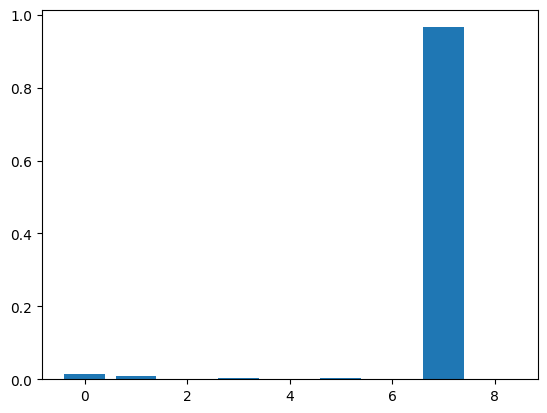

In [43]:
import matplotlib.pyplot as plt

ttt = TicTacToe()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

state = ttt.get_initial_state()
state = ttt.get_next_state(state, 2, -1)
state = ttt.get_next_state(state, 4, -1)
state = ttt.get_next_state(state, 6, 1)
state = ttt.get_next_state(state, 8, 1)

print(state)

encoded_state = ttt.get_encoded_state(state)

print(encoded_state)

tensor_state = torch.tensor(encoded_state, device=device).unsqueeze(0)

model = ResNet(ttt, 4, 64, device=device)
model.load_state_dict(torch.load('model_2.pt', map_location=device))
model.eval()

policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print(value)

plt.bar(range(ttt.action_size), policy)
plt.show()

In [38]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior

        self.children = []

        self.visit_count = visit_count
        self.value_sum = 0

    def is_expanded(self):
        return len(self.children) > 0

    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb

        return best_child

    def get_ucb(self, child):
        ''' Get how promising a move is from the opponent's perspective, normalized on [0,1] '''
        if child.visit_count == 0:
            q = 0
        else:
            q = 1 - ((child.value_sum / child.visit_count) + 1) / 2 

        return q + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior

    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)
        
                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        # flip value for opponent (parent)
        value = self.game.get_opponent_value(value)

        if self.parent is not None:
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model

    @torch.no_grad()
    def search(self, state):
        # DEFINE ROOT
        root = Node(self.game, self.args, state, visit_count=1)

        # add some random noise to policy to increase exploration
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state), device=self.model.device).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = ((1 - self.args['dirichlet_epsilon']) * 
                    policy + 
                    self.args['dirichlet_epsilon'] * 
                    np.random.dirichlet([self.args['dirichlet_alpha']] * 
                    self.game.action_size
                ))
        valid_moves = self.game.get_valid_moves(state)
        policy *= valid_moves
        policy /= np.sum(policy)
        root.expand(policy)
        
        for search in range(self.args['num_searches']):
            node = root
            
            # SELECTION
            while node.is_expanded():
                node = node.select()
                
            # check for end of game
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)

            # flip parent value
            value = self.game.get_opponent_value(value)

            if not is_terminal:
                # get output from model
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state), device=self.model.device).unsqueeze(0)
                )

                # change policy to proabability distribution
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()

                # mask out illegal moves
                valid_moves = self.game.get_valid_moves(node.state)
                policy *= valid_moves

                # readjust back to probability distribution
                policy /= np.sum(policy)

                # get the value as a number from singleton tensor
                value = value.item()
                
                # EXPANSION
                node.expand(policy)
    
            # BACKPROP
            node.backpropagate(value)

        # probabilities of action being good
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count

        action_probs /= np.sum(action_probs)
        return action_probs

In [44]:
class AlphaZero:
    ''' AlphaZero class for self-play and training '''
    
    def __init__(self, model, optimizer, game, args):
        ''' Initialize the AlphaZero instance '''
        self.model = model
        self.optimizer = optimizer
        self.game = game
        self.args = args
        self.mcts = MCTS(game, args, model)

    def self_play(self):
        ''' Run a single self-play game until completion and generate outcome-appended training data '''
        
        memory = []
        player = 1
        state = self.game.get_initial_state()

        while True:
            # get the current state and action probabilities from MCTS
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)

            # record a game snapshot
            memory.append((neutral_state, action_probs, player))

            # randomly sample an action from the distribution
            adjusted_action_probs = action_probs ** (1 / self.args['temperature']) # add flexibility for exploration / exploitation
            adjusted_action_probs /= np.sum(adjusted_action_probs)
            action = np.random.choice(self.game.action_size, p=adjusted_action_probs)

            # get the next state given the chosen action
            state = self.game.get_next_state(state, action, player)

            # check for game completion
            value, is_terminal = self.game.get_value_and_terminated(state, action)

            if is_terminal:
                # get all states and policies from the game and append the outcome
                return [(
                    self.game.get_encoded_state(h_state),
                    h_action_probs,
                    value if h_player == player else self.game.get_opponent_value(value)
                ) for h_state, h_action_probs, h_player in memory]

            # swap the player and loop
            player = self.game.get_opponent(player)

    def train(self, memory):
        ''' Train the model '''

        # randomize training data
        random.shuffle(memory)
        
        for batch_i in range(0, len(memory), self.args['batch_size']):
            # sample a batch from training data
            sample = memory[batch_i : min(len(memory) - 1, batch_i + self.args['batch_size'])]

            # transpose list of tuples to independent lists
            state, policy_targets, value_targets = zip(*sample)

            # convert to numpy arrays
            state = np.array(state)
            policy_targets = np.array(policy_targets)
            value_targets = np.array(value_targets).reshape(-1, 1) # wrap each value in its own array for simplicity later

            # convert to tensors
            state = torch.tensor(state, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)

            # get model outputs
            out_policy, out_value = self.model(state)

            # get loss
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            # minimize loss via backpropagation
            self.optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def learn(self):
        ''' Generate self-play training data and train the model on it '''
        
        for iter in range(self.args['num_iters']):
            memory = []
            
            self.model.eval()
            for self_play_iter in trange(self.args['num_self_play_iters']):
                memory += self.self_play()

            self.model.train()
            for epoch in trange(self.args['num_epochs']):
                self.train(memory)

            torch.save(self.model.state_dict(), f'models/{self.game}/model_{iter}.pt')
            torch.save(self.optimizer.state_dict(), f'models/{self.game}/optimizer_{iter}.pt')

In [42]:
ttt = TicTacToe()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ResNet(ttt, 4, 64, device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

args = {
    'C': 2,
    'num_searches': 60,
    'num_iters': 3,
    'num_self_play_iters': 500,
    'num_epochs': 4,
    'batch_size': 64,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}

alphazero = AlphaZero(model, optimizer, ttt, args)
alphazero.learn()

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
ttt = TicTacToe()
player = 1

args = {
    'C': 2,
    'num_searches': 1000
}

model = ResNet(ttt, 4, 64)
model.eval()

mcts = MCTS(ttt, args, model)

state = ttt.get_initial_state()

while True:
    print(state)

    if player == 1:
        valid_moves = ttt.get_valid_moves(state)
        print('Valid Moves:' , [i for i in range(ttt.action_size) if valid_moves[i] == 1])
        action = int(input(f'{player}: '))
    
        if valid_moves[action] == 0:
            print('Invalid move')
            continue
    else:
        neutral_state = ttt.change_perspective(state, player)
        mcts_probs = mcts.search(neutral_state)
        action = np.argmax(mcts_probs)

    state = ttt.get_next_state(state, action, player)

    value, is_terminal = ttt.get_value_and_terminated(state, action)

    if is_terminal:
        print(state)
        if value == 1:
            print(player, 'won')
        else:
            print('Draw')
        break

    player = ttt.get_opponent(player)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Valid Moves: [0, 1, 2, 3, 4, 5, 6, 7, 8]


1:  0


[[1. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 1.  0.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  0.]]
Valid Moves: [1, 2, 3, 5, 6, 7, 8]


1:  1


[[ 1.  1.  0.]
 [ 0. -1.  0.]
 [ 0.  0.  0.]]
[[ 1.  1. -1.]
 [ 0. -1.  0.]
 [ 0.  0.  0.]]
Valid Moves: [3, 5, 6, 7, 8]


1:  8


[[ 1.  1. -1.]
 [ 0. -1.  0.]
 [ 0.  0.  1.]]
[[ 1.  1. -1.]
 [ 0. -1.  0.]
 [-1.  0.  1.]]
-1 won
